In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import os

Change runningfromscratch to true if running without the data files and only this notebook

In [ ]:
runningFromScratch = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


load the minist dataset

In [ ]:
batch = 1000
t = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(mean=(0), std=(1))]
                       )
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,transform = t)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,transform = t)

train_loader = DataLoader(dataset=mnist_trainset,batch_size=batch,shuffle = True,num_workers=2)
test_loader = DataLoader(dataset=mnist_testset,batch_size=batch,shuffle = True,num_workers=2)


initialize a simple mlp model

In [ ]:
class Model(nn.Module):
    def __init__(self, input,hidden,output):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input,hidden)
        self.bn1 = nn.BatchNorm1d(hidden)
        self.fc4 = nn.Linear(hidden,output)

    def forward(self, c):
        x = self.fc1(c)
        x = self.bn1(x)
        x = self.fc4(x)
        return x
    

MLP_model = Model(28*28,1028,10).cuda()

the implementation of the algorithm of fast gradient sign method, but instead of untargeted, we perform targeted attack

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    
    sign_data_grad = data_grad.sign()
    
    perturbed_image = image - epsilon*sign_data_grad
    
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

a val function to evalute accuracy of the model

In [ ]:
def val (outputs,labels):
    correct = 0
    for i in range(len(labels)):
        if labels[i] == torch.argmax(outputs[i]):
            correct+=1
        
    return correct/1000*100

In [ ]:
path = '/content/drive/MyDrive/FGSM'
isExist = os.path.exists(path)
if not isExist:
    os.makedirs(path)

else:
    print('Directory already exist!')

Directory already exist!


train the model for 10 epoches

epoch: 1, training loss: 1.1725143735607466, testing loss:0.526548421382904
epoch: 2, training loss: 0.44775665799776715, testing loss:0.3548291981220245
epoch: 3, training loss: 0.3528510535756747, testing loss:0.3341348946094513
epoch: 4, training loss: 0.31433021823565166, testing loss:0.30094670355319975
epoch: 5, training loss: 0.2981382677952448, testing loss:0.29118427336215974
epoch: 6, training loss: 0.2852204511562983, testing loss:0.29477363973855975
epoch: 7, training loss: 0.28993273799618086, testing loss:0.3139543890953064
epoch: 8, training loss: 0.2882877399524053, testing loss:0.28675042241811755
epoch: 9, training loss: 0.2780670973161856, testing loss:0.28259105831384657
epoch: 10, training loss: 0.2751145030061404, testing loss:0.2972705602645874
Finished Training


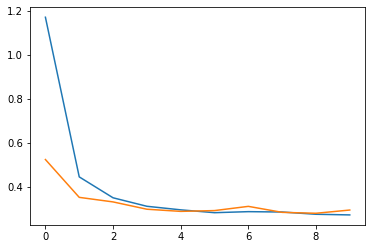

In [ ]:
MLP_model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(MLP_model.parameters(), lr=0.5, momentum=0.9)
graph = []
graph2 = []
for epoch in range(10):  
    
    train_running_loss = 0.0
    test_running_loss=0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        inputs, labels  = inputs.cuda(), labels.cuda()
        
        
        inputs = inputs.view(inputs.size(0),-1)
        
        optimizer.zero_grad()
        
        outputs = MLP_model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
      
        
        train_running_loss += loss.item()
        

    
    for i, data in enumerate(test_loader, 0):
        
        inputs, labels = data
        inputs, labels  = inputs.cuda(), labels.cuda()
        
        inputs = inputs.view(inputs.size(0),-1)
      
        outputs = MLP_model(inputs)

        loss2 = criterion(outputs, labels)
        
        test_running_loss += loss2.item()
        


    graph.append(train_running_loss/len(train_loader))
    graph2.append(test_running_loss/len(test_loader))

    print(f'epoch: {epoch + 1}, training loss: {train_running_loss/len(train_loader)}, testing loss:{test_running_loss/(len(test_loader))}')
        

print('Finished Training')

plt.plot(graph)
plt.plot(graph2)

if runningFromScratch:
  torch.save(MLP_model.state_dict(), f'{path}/FGSM.pth' )


else: 
  MLP_model.load_state_dict(torch.load(f'{path}/FGSM.pth' ))

evalute the model

In [ ]:
total_acc = 0
for i, data in enumerate(test_loader, 0):
       
        inputs, labels  = data
        inputs, labels = inputs.cuda(), labels.cuda()
        inputs = inputs.view(inputs.size(0),-1)
        
        outputs = MLP_model(inputs)
       
        acc = val(outputs,labels)
        total_acc += acc
        
        
        
print(f'Accuracy: {total_acc/len(test_loader)}%')
        

print('Finished testing')

Accuracy: 91.67%
Finished testing


In [ ]:
MLP_model.eval()

Model(
  (fc1): Linear(in_features=784, out_features=1028, bias=True)
  (bn1): BatchNorm1d(1028, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=1028, out_features=10, bias=True)
)

Text(0.5, 1.0, '0 to 9')

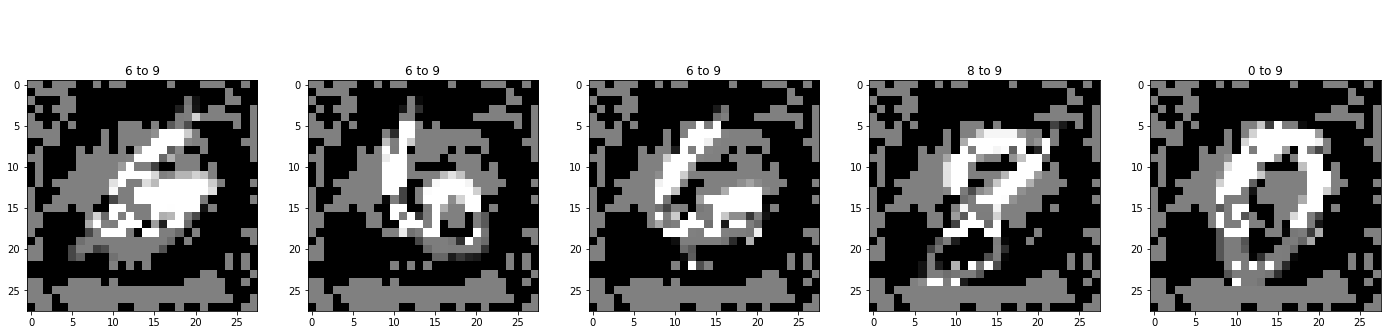

In [ ]:
pert_imgs = []
ori_class = []
pert_class = []

while len(ori_class) <= 5:
  chosen = np.random.randint(0,10000)
  test_img = mnist_testset[chosen][0].cuda()
  ori_label = mnist_testset[chosen][1]
  for i in range(10):
      inputs = mnist_testset[chosen][0].view(-1).unsqueeze(0).cuda()
      label = torch.LongTensor([mnist_testset[chosen][1]]).cuda()
      inputs.requires_grad = True
      
      target = torch.LongTensor([9]).cuda()
      
      output = MLP_model(inputs)
      if torch.argmax(output).item()!= label:
          continue

      loss = F.nll_loss(output,target)
  
      MLP_model.zero_grad()


      loss.backward()


      data_grad = inputs.grad.data

      
      perturbed_data = fgsm_attack(inputs, 0.5, data_grad)

      
      output = MLP_model(perturbed_data)
      
      if torch.argmax(output).item()!= label.item():
          ori_class.append(ori_label)
          pert_imgs.append(perturbed_data)
          pert_class.append(torch.argmax(MLP_model(perturbed_data)))
          break

  '''print(f'original prediction: {torch.argmax(MLP_model(test_img.view(-1).unsqueeze(0))).item()}')
  print(f'pertubated prediction: {torch.argmax(MLP_model(perturbed_data)).item()}')'''

gap = 0.65      
plt.axes([2.4,-1,0.6,0.8])
plt.imshow(pert_imgs[0].cpu().detach().numpy().squeeze().reshape(28,28),cmap='gray')
plt.title(f'{ori_class[0]} to {pert_class[0]}')

gap = 0.65      
plt.axes([2.4+gap,-1,0.6,0.8])
plt.imshow(pert_imgs[1].cpu().detach().numpy().squeeze().reshape(28,28),cmap='gray')
plt.title(f'{ori_class[1]} to {pert_class[1]}')

gap = 0.65      
plt.axes([2.4+gap*2,-1,0.6,0.8])
plt.imshow(pert_imgs[2].cpu().detach().numpy().squeeze().reshape(28,28),cmap='gray')
plt.title(f'{ori_class[2]} to {pert_class[2]}')

gap = 0.65      
plt.axes([2.4+gap*3,-1,0.6,0.8])
plt.imshow(pert_imgs[3].cpu().detach().numpy().squeeze().reshape(28,28),cmap='gray')
plt.title(f'{ori_class[3]} to {pert_class[3]}')

gap = 0.65      
plt.axes([2.4+gap*4,-1,0.6,0.8])
plt.imshow(pert_imgs[4].cpu().detach().numpy().squeeze().reshape(28,28),cmap='gray')
plt.title(f'{ori_class[4]} to {pert_class[4]}')


